In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, StackingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from scipy.stats import mode
from tqdm import tqdm
from sklearn.datasets import make_classification



In [ ]:
file_path = '/SCORES.xlsx'
dataset = pd.read_excel(file_path)

Results using all features together:
                     Train Accuracy  Train Precision  Train Recall  \
Logistic Regression        0.614894         0.621629      0.614894   
Random Forest              0.721277         0.718506      0.721277   
Gradient Boosting          0.702128         0.699724      0.702128   
SVM                        0.644681         0.665416      0.644681   
XGB                        0.719149         0.714188      0.719149   

                     Train F1 Score  Test Accuracy  Test Precision  \
Logistic Regression        0.618047       0.549296        0.595473   
Random Forest              0.705885       0.577465        0.568226   
Gradient Boosting          0.685549       0.570423        0.552934   
SVM                        0.642961       0.549296        0.600829   
XGB                        0.703396       0.563380        0.539860   

                     Test Recall  Test F1 Score  
Logistic Regression     0.549296       0.553483  
Random Forest        

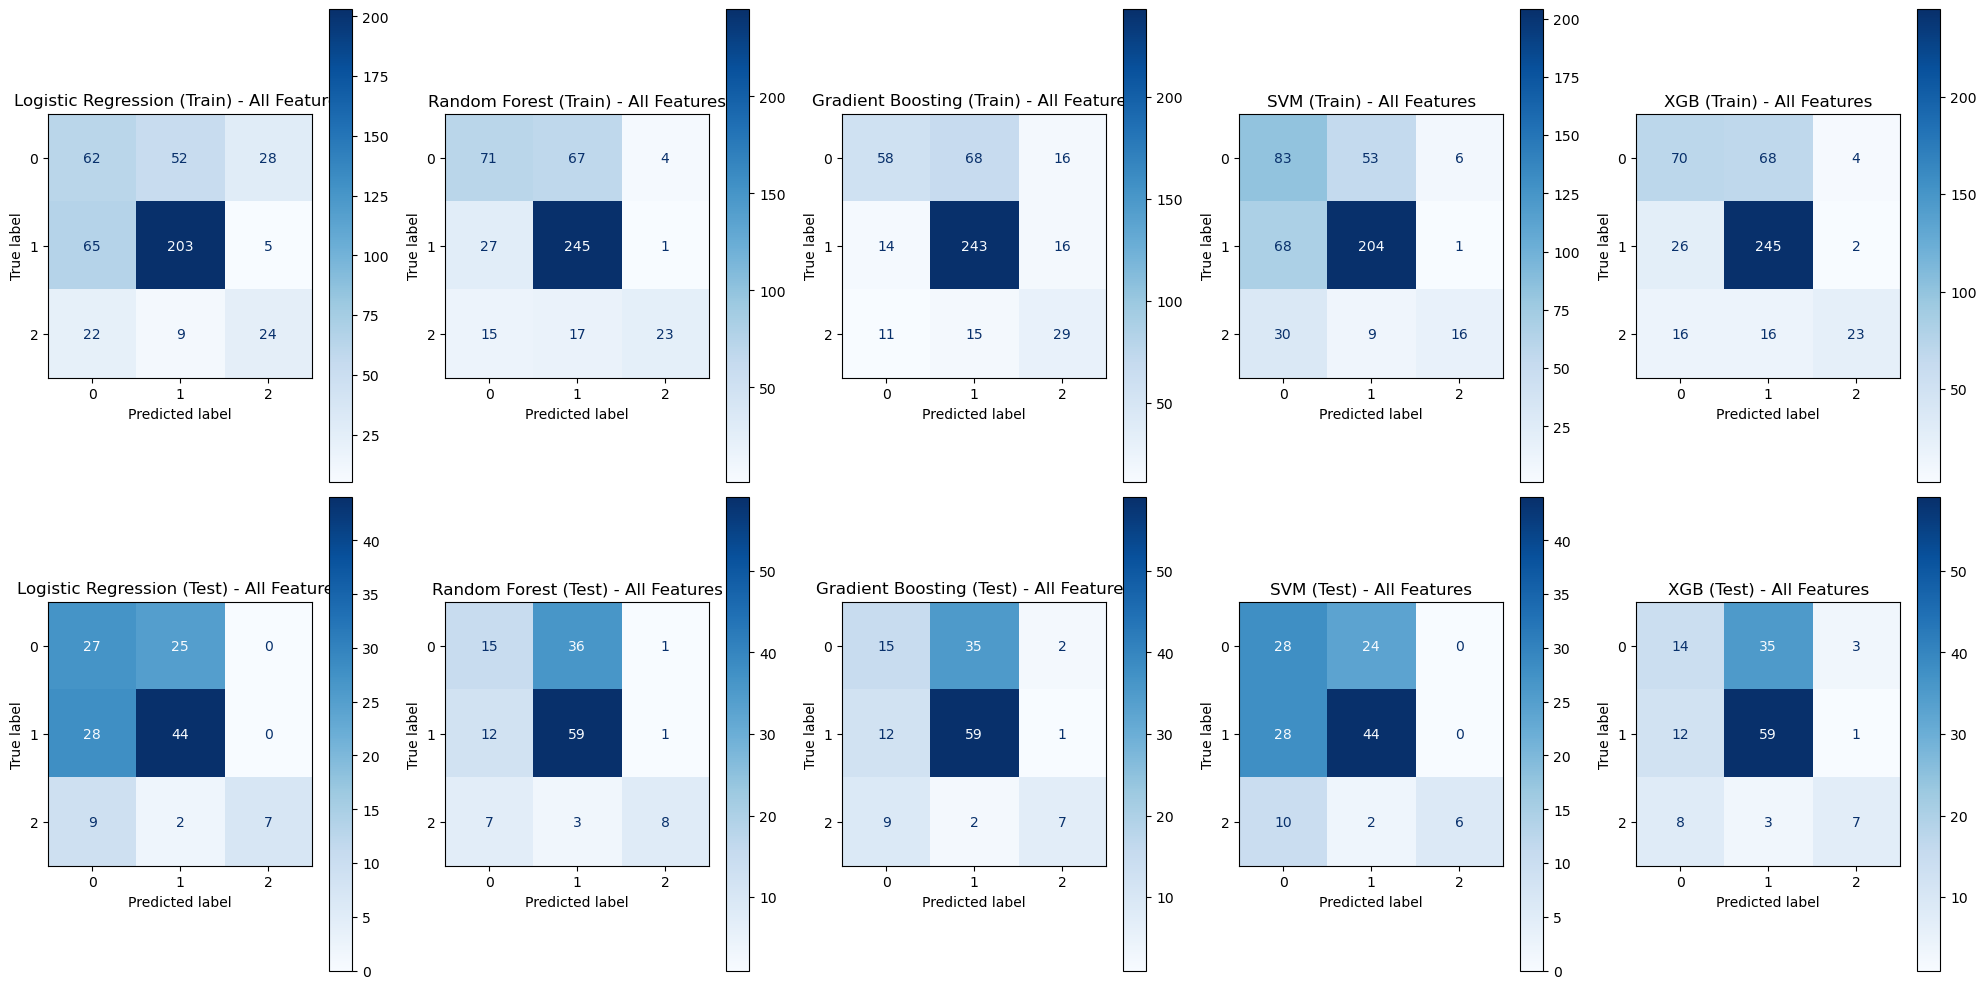

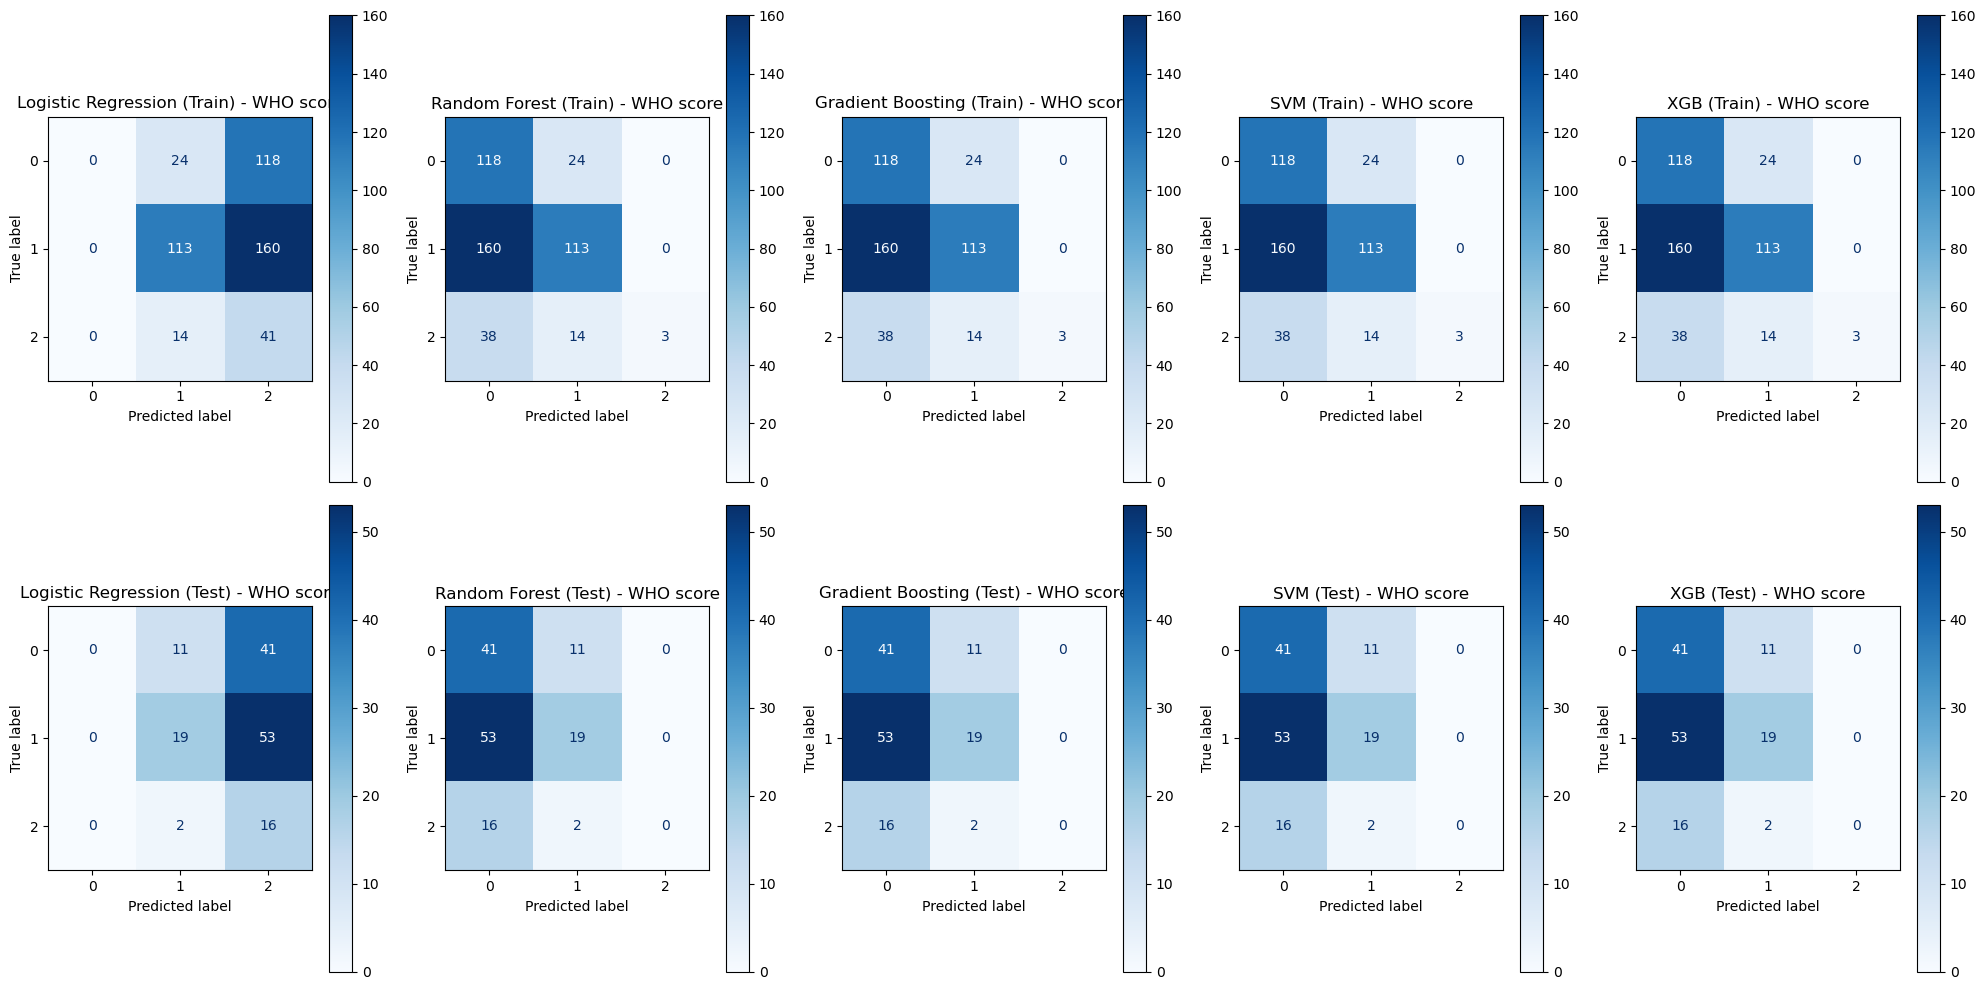

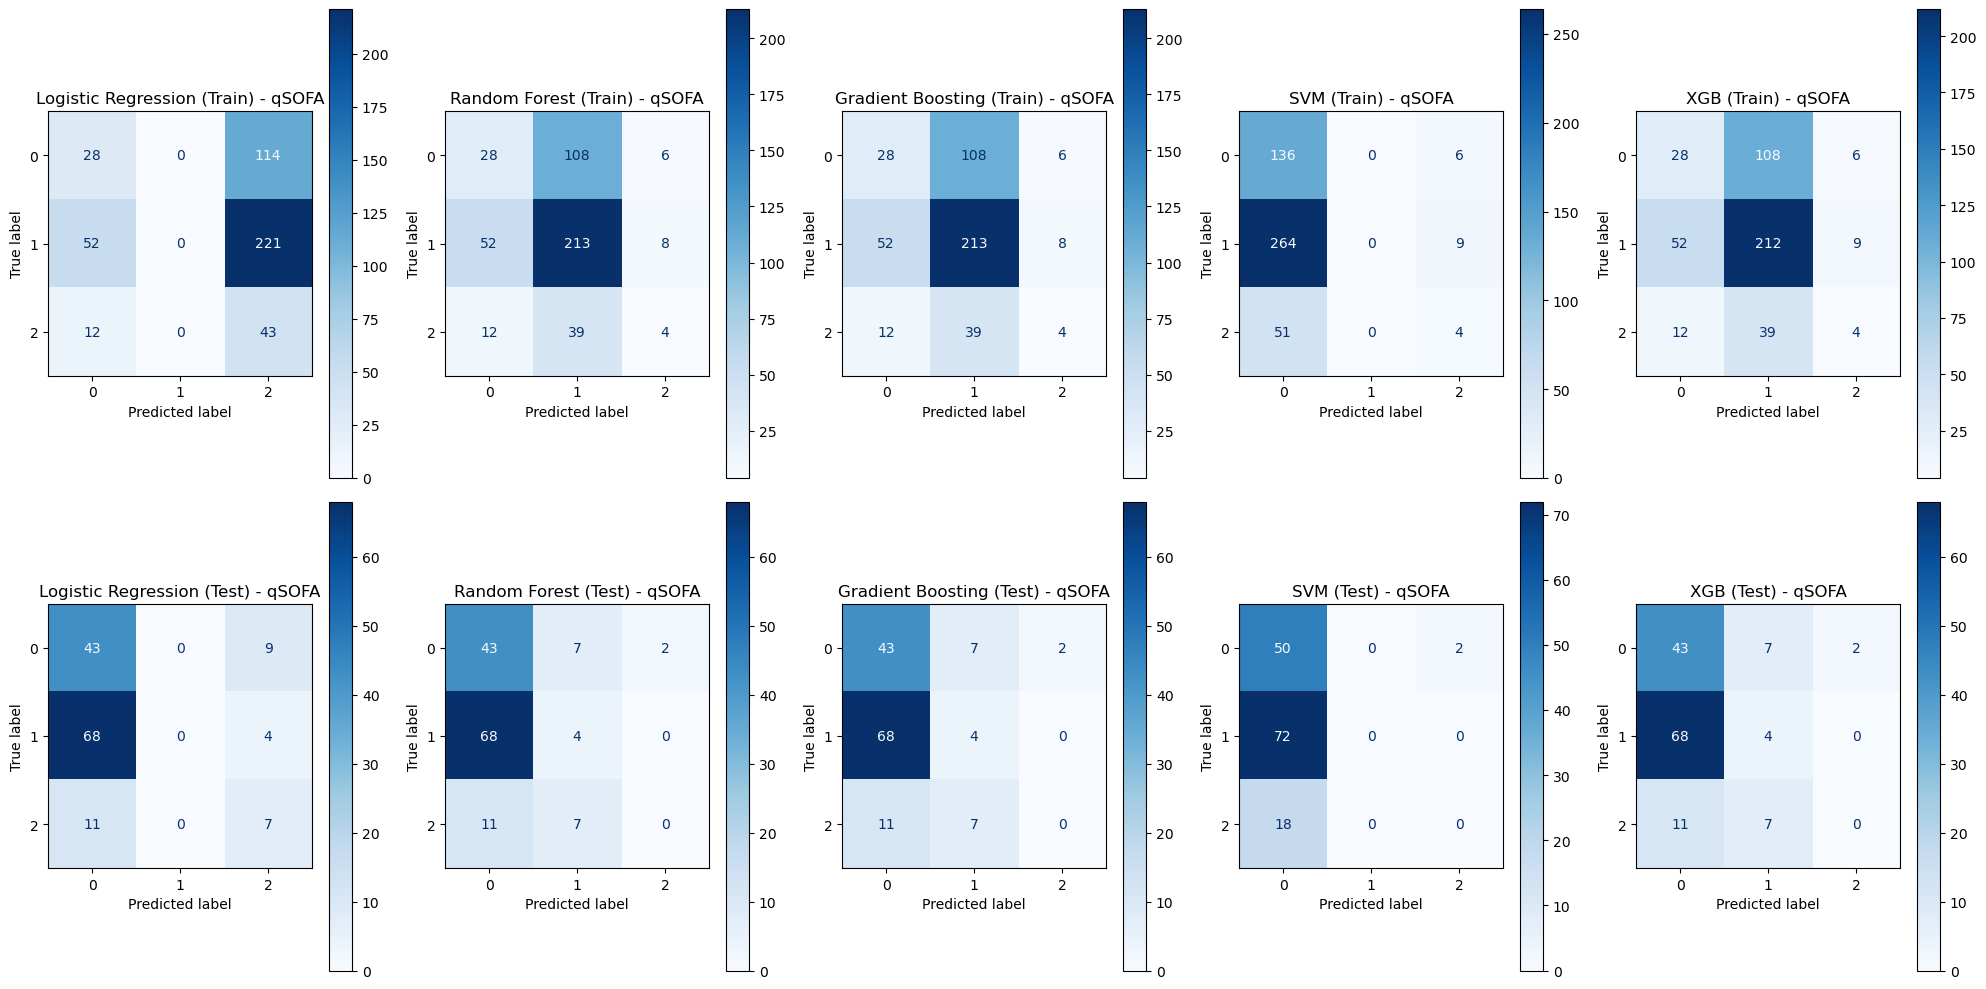

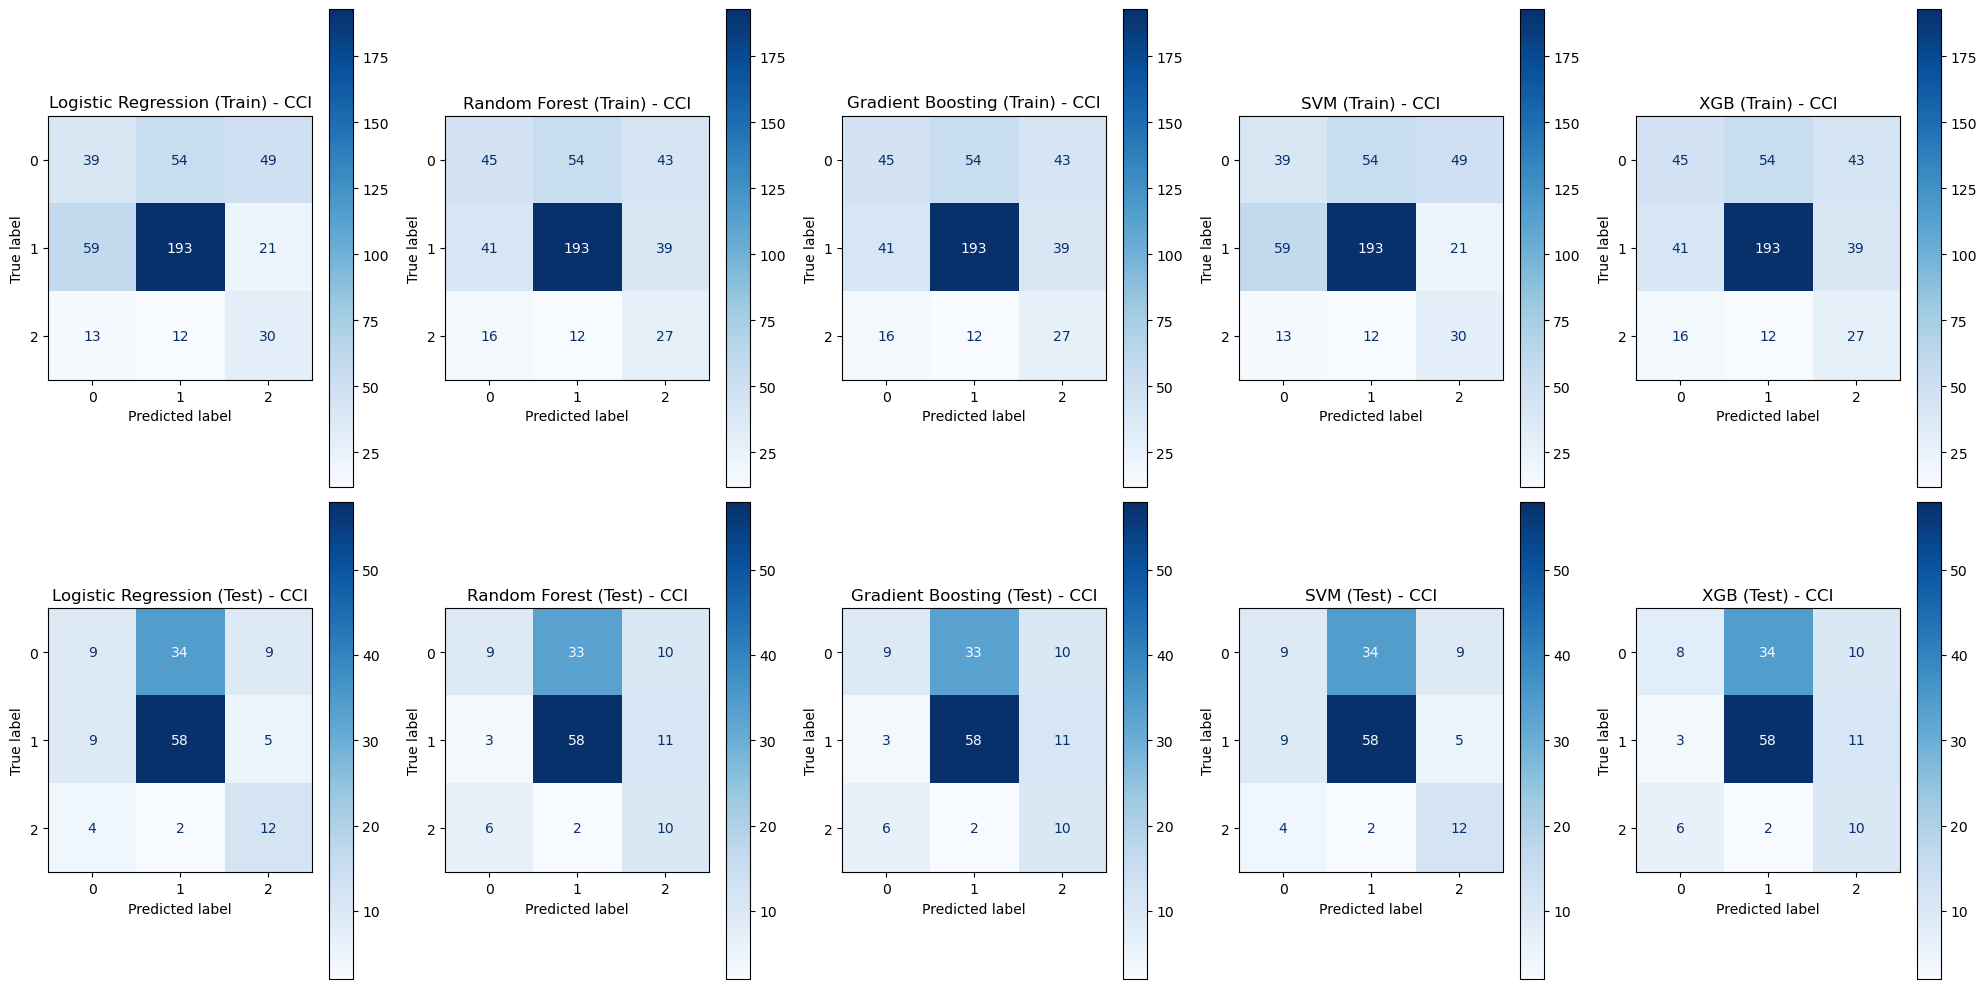

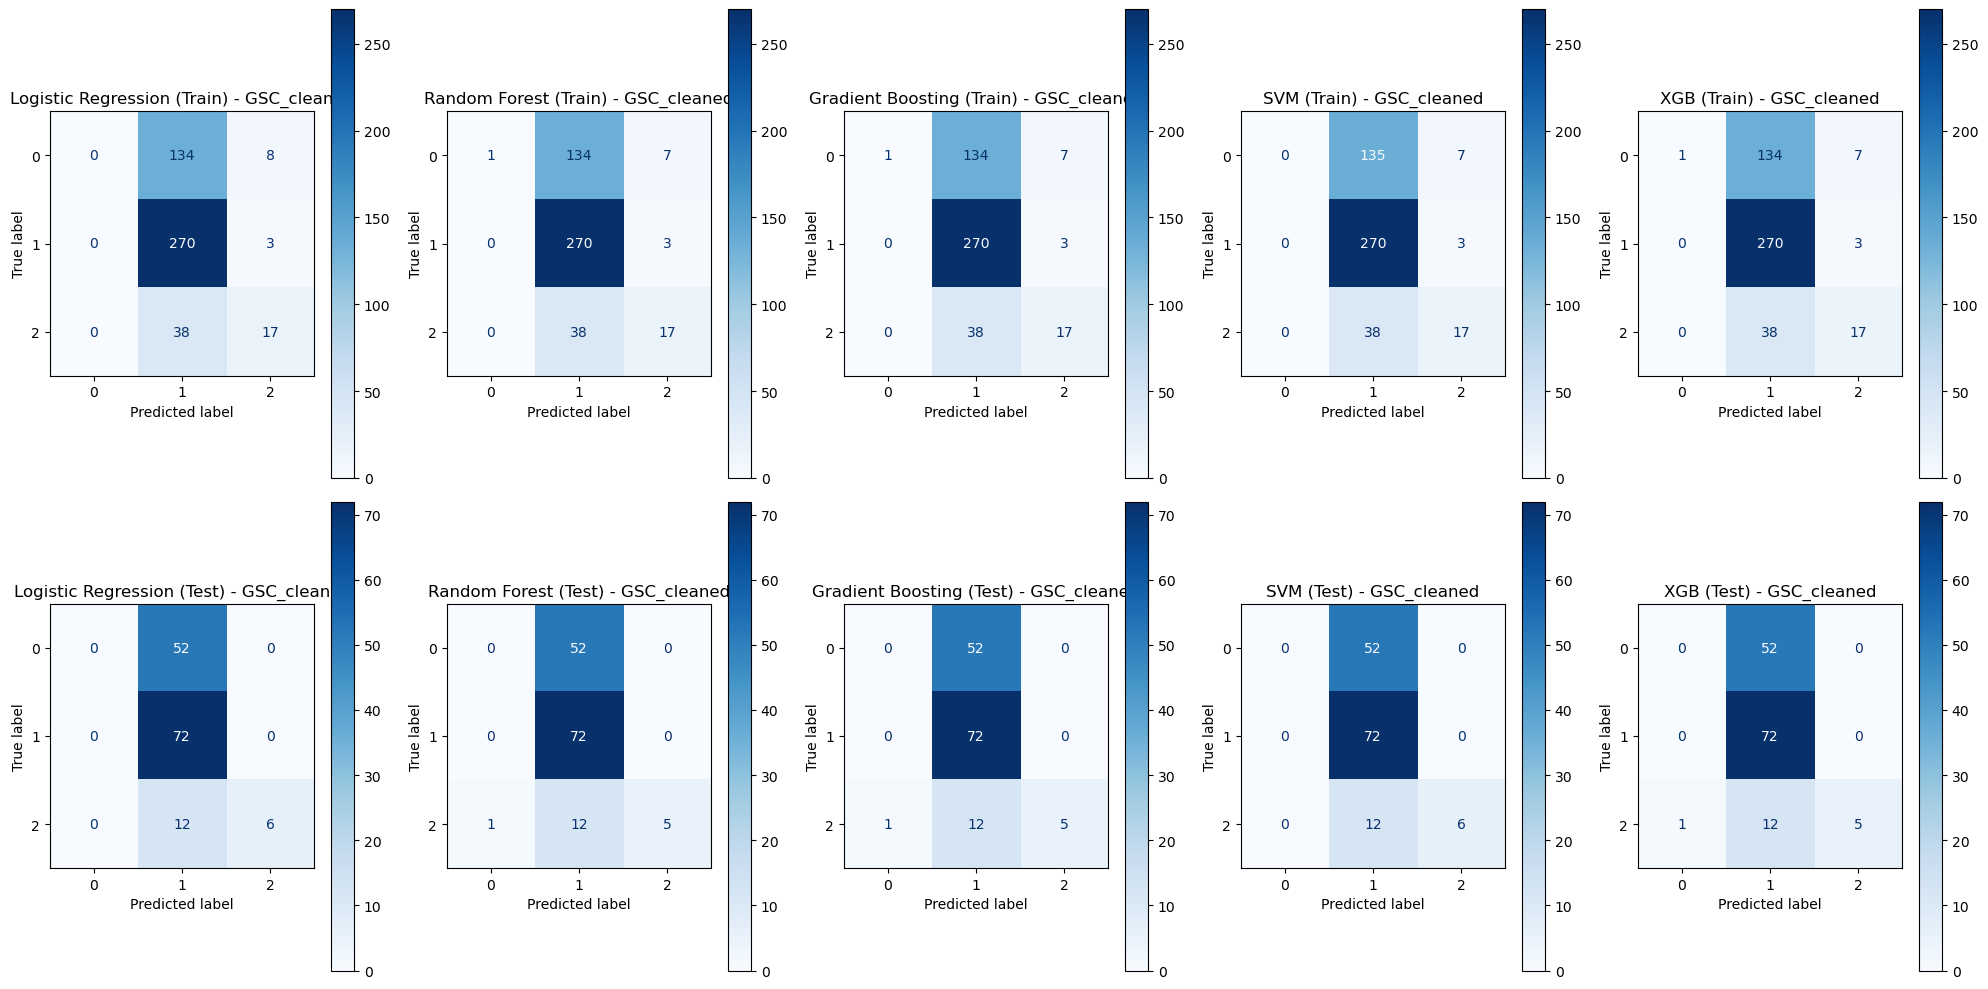

In [11]:
# Drop columns that contain 'Medication_' in their name
cols_to_drop = dataset.filter(like='Medication_').columns
dataset = dataset.drop(columns=cols_to_drop)

# Filter dataset where 'Original_4_or_5' column is 0 for training data
train_dataset = dataset[dataset['Original_4_or_5'] == 0]
train_dataset = train_dataset.drop(columns=['Original_4_or_5'])

# Filter dataset where 'Original_4_or_5' column is 1 for testing data
test_dataset = dataset[dataset['Original_4_or_5'] == 1]
test_dataset = test_dataset.drop(columns=['Original_4_or_5'])



# Features to be used for prediction
features = ['WHO score', 'qSOFA', 'CCI', 'GSC_cleaned']

# Function to train and evaluate models
def train_evaluate_models(X_train, y_train, X_test, y_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

    models = {
    'Logistic Regression': LogisticRegression(max_iter=10000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='linear', random_state=42),
    'XGB': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42, objective='binary:logistic'),
}

    results = {}
    conf_matrices_train = {}
    conf_matrices_test = {}

    for name, model in models.items():
        model.fit(X_train_smote, y_train_smote)
        y_train_pred = model.predict(X_train_scaled)
        y_test_pred = model.predict(X_test_scaled)

        results[name] = {
            'Train Accuracy': accuracy_score(y_train, y_train_pred),
            'Train Precision': precision_score(y_train, y_train_pred, average='weighted', zero_division=0),
            'Train Recall': recall_score(y_train, y_train_pred, average='weighted', zero_division=0),
            'Train F1 Score': f1_score(y_train, y_train_pred, average='weighted', zero_division=0),
            'Test Accuracy': accuracy_score(y_test, y_test_pred),
            'Test Precision': precision_score(y_test, y_test_pred, average='weighted', zero_division=0),
            'Test Recall': recall_score(y_test, y_test_pred, average='weighted', zero_division=0),
            'Test F1 Score': f1_score(y_test, y_test_pred, average='weighted', zero_division=0)
        }

        conf_matrices_train[name] = confusion_matrix(y_train, y_train_pred)
        conf_matrices_test[name] = confusion_matrix(y_test, y_test_pred)

    results_df = pd.DataFrame(results).T
    return results_df, conf_matrices_train, conf_matrices_test, models

# Train and evaluate using all features together
X_train_all = train_dataset[features]
y_train = train_dataset['Outcome_numerical']
X_test_all = test_dataset[features]
y_test = test_dataset['Outcome_numerical']

results_all, conf_matrices_train_all, conf_matrices_test_all, models_all = train_evaluate_models(X_train_all, y_train, X_test_all, y_test)

# Train and evaluate using each feature separately
results_separate = {}
conf_matrices_train_separate = {}
conf_matrices_test_separate = {}
models_separate = {}

for feature in features:
    X_train_single = train_dataset[[feature]]
    X_test_single = test_dataset[[feature]]
    
    results, conf_matrices_train, conf_matrices_test, models = train_evaluate_models(X_train_single, y_train, X_test_single, y_test)
    
    results_separate[feature] = results
    conf_matrices_train_separate[feature] = conf_matrices_train
    conf_matrices_test_separate[feature] = conf_matrices_test
    models_separate[feature] = models

# Display results for all features together
print("Results using all features together:")
print(results_all)

# Display results for each feature separately
for feature in features:
    print(f"\nResults using {feature} feature:")
    print(results_separate[feature])

# Visualization of Confusion Matrices for all features together
fig, axes = plt.subplots(nrows=2, ncols=len(models_all), figsize=(20, 10))
for ax, (name, matrix) in zip(axes[0], conf_matrices_train_all.items()):
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    ax.title.set_text(f"{name} (Train) - All Features")
for ax, (name, matrix) in zip(axes[1], conf_matrices_test_all.items()):
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    ax.title.set_text(f"{name} (Test) - All Features")
plt.tight_layout()
plt.show()

# Visualization for separate features
for feature in features:
    fig, axes = plt.subplots(nrows=2, ncols=len(models_separate[feature]), figsize=(20, 10))
    for ax, (name, matrix) in zip(axes[0], conf_matrices_train_separate[feature].items()):
        disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
        disp.plot(ax=ax, cmap=plt.cm.Blues)
        ax.title.set_text(f"{name} (Train) - {feature}")
    for ax, (name, matrix) in zip(axes[1], conf_matrices_test_separate[feature].items()):
        disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
        disp.plot(ax=ax, cmap=plt.cm.Blues)
        ax.title.set_text(f"{name} (Test) - {feature}")
    plt.tight_layout()
    plt.show()